## Classification on 8 celebrities

In this notebook we try to classify images of : "Miranda_Cosgrove" "Chris_Martin" "Emma_Stone" "Jamie_Foxx" "Steve_Jobs" "Zac_Efron" "Sandra_Oh" "Taryn_Manning". There are 350 images of each celebrity, we use 250 for traning and 50 for validation and test.

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
import h5py

Reading in the data, it is already prepared in a train, validation and testset. The class labels are form 0 to 7. The pixelsize of every image is 48x48 and we have 3 channels (RGB) per image. All 3 sets are balanced.

In [2]:
# Downloading the data, if it does not exist, this will take some time... (>120MB)
import urllib
import os
if not os.path.isfile('8_faces_train_and_valid.hdf5'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/dx03vk6dmbtoywn/8_faces_train_and_valid.hdf5?dl=1",
    "8_faces_train_and_valid.hdf5")

In [3]:
h5f_X = h5py.File('8_faces_train_and_valid.hdf5', 'r')
print(list(h5f_X.keys()))
X_train = h5f_X['X_train_8_faces']
print(X_train.shape)
Y_train = h5f_X['Y_train_8_faces']
print(Y_train.shape)
X_valid = h5f_X['X_valid_8_faces']
print(X_valid.shape)
Y_valid = h5f_X['Y_valid_8_faces']
print(Y_valid.shape)

['X_train_8_faces', 'X_valid_8_faces', 'Y_train_8_faces', 'Y_valid_8_faces']
(2000, 48, 48, 3)
(2000,)
(400, 48, 48, 3)
(400,)


(array([ 250.,  250.,  250.,  250.,  250.,  250.,  250.,  250.]),
 array([ 0.   ,  0.875,  1.75 ,  2.625,  3.5  ,  4.375,  5.25 ,  6.125,  7.   ]),
 <a list of 8 Patch objects>)

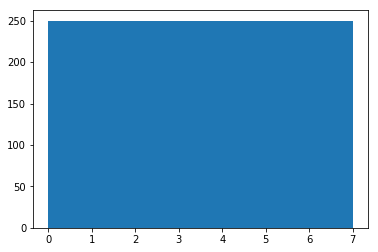

In [4]:
plt.hist(Y_train,bins=8)

(array([ 50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.]),
 array([ 0.   ,  0.875,  1.75 ,  2.625,  3.5  ,  4.375,  5.25 ,  6.125,  7.   ]),
 <a list of 8 Patch objects>)

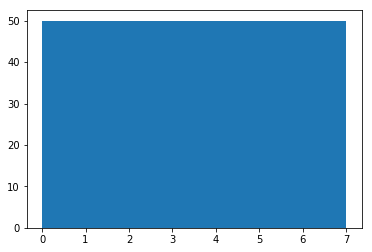

In [5]:
plt.hist(Y_valid,bins=8)

How hard is this task? Lets plot some random image of the trainset to get an impression of the images and of  the task. 

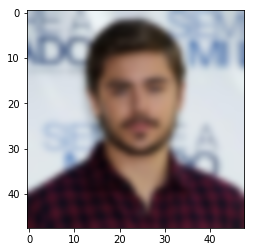

In [9]:
rmd=np.random.randint(0,len(X_train))
plt.imshow(np.asarray(X_train[rmd],dtype="uint8"),interpolation="bicubic")

#### Normalization of the training and validationset.

In [7]:
X_mean = np.mean( X_train, axis = 0)
X_std = np.std( X_train, axis = 0)

X_train = (X_train - X_mean ) / (X_std + 0.0001)
X_valid = (X_valid - X_mean ) / (X_std + 0.0001)

#### Flattern the images into a vector because we unly use fully connected layers in this model

In [7]:
#X_train_flatten=np.zeros([len(X_train),48*48*3])
#for i in range(0,len(X_train)):
#    X_train_flatten[i]=np.reshape(X_train[i],newshape=((48*48*3),))
#    
#X_valid_flatten=np.zeros([len(X_valid),48*48*3])
#for i in range(0,len(X_valid)):
#    X_valid_flatten[i]=np.reshape(X_valid[i],newshape=((48*48*3),))
#print(X_train_flatten.shape)
#print(X_valid_flatten.shape)

(2000, 6912)
(400, 6912)


Define the convertToOneHot function and convert the labels into the onehot encoding.

In [8]:
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='int32')
    result[np.arange(len(vector)), vector] = 1
    return result

In [9]:
Y_train=convertToOneHot(Y_train,num_classes=8)
Y_valid=convertToOneHot(Y_valid,num_classes=8)

In [10]:
print(Y_train[13])
print(Y_valid[13])

[0 0 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0]


### Define the network

In [11]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [16]:
batch_size = 128
nb_classes = 8
nb_epoch = 50

In [17]:
model = Sequential()
name = 'only_fc'

model.add(Dense(400,input_dim=(48*48*3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(500))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               2765200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)               1600      
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               200500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________________________________________________________________
activation_2 (Activation)    (None, 500)               0         
__________

### Running a forward pass of the untrained network

In [19]:
model.evaluate(X_train_flatten,Y_train)

2000/2000 [==============================] - 0s 209us/step


[2.2616856632232665, 0.13]

In [20]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/8_faces/' + name + '/', 
        write_graph=True,
        histogram_freq=1)

In [21]:
#save model after every 10 epochs in "Checkpoints/8_facesl/model_1_fc/"-folder
os.makedirs("Checkpoints/8_faces/model_1_fc/",exist_ok=True)       
checkpointer = keras.callbacks.ModelCheckpoint( 
        filepath =  "Checkpoints/8_faces/model_1_fc/fc_model_"+"weights_epoch_{epoch:03d}-{val_loss:.2f}.hdf5",
        verbose = 1, 
        save_best_only = False,
        period = 10 )

### Training the network

In [22]:
history=model.fit(X_train_flatten, Y_train, 
                  batch_size=batch_size, 
                  epochs=nb_epoch,
                  verbose=2, 
                  validation_data=(X_valid_flatten, Y_valid),
                  callbacks=[tensorboard,checkpointer],)

Train on 2000 samples, validate on 400 samples
Epoch 1/50
 - 3s - loss: 2.3881 - acc: 0.1980 - val_loss: 2.0189 - val_acc: 0.3075
Epoch 2/50
 - 3s - loss: 2.0566 - acc: 0.2780 - val_loss: 1.7458 - val_acc: 0.3650
Epoch 3/50
 - 2s - loss: 1.9968 - acc: 0.2730 - val_loss: 1.6914 - val_acc: 0.4175
Epoch 4/50
 - 2s - loss: 1.8894 - acc: 0.3355 - val_loss: 1.5791 - val_acc: 0.4425
Epoch 5/50
 - 2s - loss: 1.7687 - acc: 0.3665 - val_loss: 1.5463 - val_acc: 0.4675
Epoch 6/50
 - 2s - loss: 1.7199 - acc: 0.3705 - val_loss: 1.4870 - val_acc: 0.4975
Epoch 7/50
 - 2s - loss: 1.6508 - acc: 0.4035 - val_loss: 1.4521 - val_acc: 0.4925
Epoch 8/50
 - 3s - loss: 1.5981 - acc: 0.4270 - val_loss: 1.4197 - val_acc: 0.4800
Epoch 9/50
 - 3s - loss: 1.5555 - acc: 0.4270 - val_loss: 1.4219 - val_acc: 0.5000
Epoch 10/50

Epoch 00010: saving model to Checkpoints/8_faces/model_1_fc/fc_model_weights_epoch_010-1.38.hdf5
 - 3s - loss: 1.4615 - acc: 0.4675 - val_loss: 1.3846 - val_acc: 0.5100
Epoch 11/50
 - 3s - loss

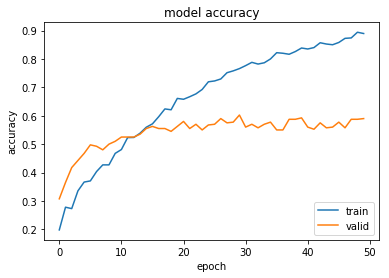

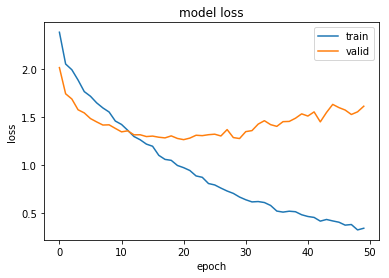

In [23]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Evaluation of the trained network

In [28]:
#load a saved model
from keras.models import load_model
model = load_model("Checkpoints/8_faces/model_1_fc/fc_model_weights_epoch_020-1.28.hdf5")

In [29]:
preds=model.predict(X_valid_flatten)

In [30]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(np.argmax(Y_valid,axis=1),np.argmax(preds,axis=1)))
print("Acc = " ,np.sum(np.argmax(Y_valid,axis=1)==np.argmax(preds,axis=1))/len(preds))

[[36  1  3  2  1  1  5  1]
 [ 1 12  2 11  9 12  0  3]
 [ 4  3 34  1  0  2  1  5]
 [ 2  1  2 37  3  3  2  0]
 [ 1  2  0  1 43  1  0  2]
 [ 3  4  5  3  3 28  2  2]
 [10  0  4  6  4  5 18  3]
 [ 4  3  9  5  4  7  1 17]]
Acc =  0.5625


### You will get the test set next week, optimize your network on the validation set

# Ok, let's see how well we do if we try to convolute...

In [11]:
# Use code from above, except flattening

In [11]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


# 01_simple_conv

In [11]:
batch_size = 64
nb_classes = 8
nb_epoch = 30
img_rows, img_cols = 48, 48
input_shape = (img_rows, img_cols, 3)
kernel_size = (3, 3)
pool_size = (2, 2)
# 48*48 = 2'304

In [13]:
model = Sequential()
name = '01_simple_conv'

# conv-layers

model.add(Convolution2D(8, kernel_size, padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(8, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))

model.add(Convolution2D(16, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(16,kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))

# fc/softmax-part

model.add(Flatten())

model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 8)         224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 8)         584       
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 8)         32        
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 8)         0         
__________

In [15]:
model.evaluate(X_train,Y_train)

2000/2000 [==============================] - 2s 874us/step


[2.2074029045104981, 0.125]

In [16]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir="tensorboard/8_faces/" + name + "/", 
        write_graph=True,
        histogram_freq=1)

In [17]:
os.makedirs("Checkpoints/8_faces/" + name + "/",exist_ok=True)       
checkpointer = keras.callbacks.ModelCheckpoint( 
        filepath =  "Checkpoints/8_faces/"+ name + "/"+"weights_epoch_{epoch:03d}-{val_loss:.2f}.hdf5",
        verbose = 1, 
        save_best_only = False,
        period = 10 )

In [18]:
history=model.fit(X_train, Y_train, 
                  batch_size=batch_size, 
                  epochs=nb_epoch,
                  verbose=2, 
                  validation_data=(X_valid, Y_valid),
                  callbacks=[tensorboard,checkpointer],)

Train on 2000 samples, validate on 400 samples
Epoch 1/30
 - 7s - loss: 2.2265 - acc: 0.2100 - val_loss: 1.8875 - val_acc: 0.2800
Epoch 2/30
 - 7s - loss: 1.7894 - acc: 0.3455 - val_loss: 1.6781 - val_acc: 0.3975
Epoch 3/30
 - 8s - loss: 1.5624 - acc: 0.4370 - val_loss: 1.5485 - val_acc: 0.4525
Epoch 4/30
 - 8s - loss: 1.4295 - acc: 0.4850 - val_loss: 1.4303 - val_acc: 0.5050
Epoch 5/30
 - 7s - loss: 1.3407 - acc: 0.5295 - val_loss: 1.3888 - val_acc: 0.5150
Epoch 6/30
 - 7s - loss: 1.2576 - acc: 0.5525 - val_loss: 1.4248 - val_acc: 0.4900
Epoch 7/30
 - 7s - loss: 1.2266 - acc: 0.5760 - val_loss: 1.3246 - val_acc: 0.5650
Epoch 8/30
 - 7s - loss: 1.1640 - acc: 0.6095 - val_loss: 1.2731 - val_acc: 0.5700
Epoch 9/30
 - 8s - loss: 1.1047 - acc: 0.6120 - val_loss: 1.2137 - val_acc: 0.5800
Epoch 10/30

Epoch 00010: saving model to Checkpoints/8_faces/01_simple_conv/weights_epoch_010-1.22.hdf5
 - 8s - loss: 1.0624 - acc: 0.6210 - val_loss: 1.2201 - val_acc: 0.5925
Epoch 11/30
 - 8s - loss: 1.0

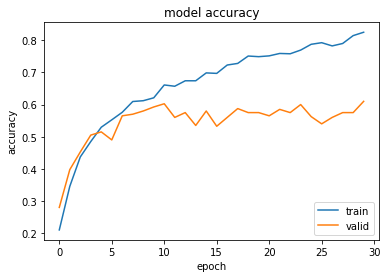

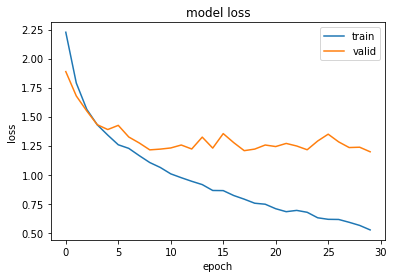

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [21]:
from keras.models import load_model
model = load_model("Checkpoints/8_faces/01_simple_conv/weights_epoch_030-1.20.hdf5")

In [22]:
preds=model.predict(X_valid)

In [23]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(np.argmax(Y_valid,axis=1),np.argmax(preds,axis=1)))
print("Acc = " ,np.sum(np.argmax(Y_valid,axis=1)==np.argmax(preds,axis=1))/len(preds))

[[32  0  3  3  0  0 10  2]
 [ 0 21  2  9  1  5  2 10]
 [ 1  2 32  1  0  0  2 12]
 [ 0  2  2 41  2  1  0  2]
 [ 0  7  0  6 30  0  1  6]
 [ 0  9  1  4  1 25  5  5]
 [ 5  1  0  4  0  4 31  5]
 [ 2  2  3  5  2  1  3 32]]
Acc =  0.61


# 02_deeper

In [12]:
batch_size = 64
nb_classes = 8
nb_epoch = 30
img_rows, img_cols = 48, 48
input_shape = (img_rows, img_cols, 3)
kernel_size = (3, 3)
pool_size = (2, 2)
# 48*48 = 2'304

In [13]:
model = Sequential()
name = '02_deeper'

# conv-layers

model.add(Convolution2D(8, kernel_size, padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(8, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))

model.add(Convolution2D(16, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(16,kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))

model.add(Convolution2D(32, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(32,kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size))

# fc/softmax-part

model.add(Flatten())

model.add(Dense(500))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(100))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(50))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 8)         224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 8)         584       
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 8)         32        
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 8)         0         
__________

In [15]:
model.evaluate(X_train,Y_train)

2000/2000 [==============================] - 2s 1ms/step


[2.0811615123748779, 0.121]

In [16]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir="tensorboard/8_faces/" + name + "/", 
        write_graph=True,
        histogram_freq=1)

In [17]:
os.makedirs("Checkpoints/8_faces/" + name + "/",exist_ok=True)       
checkpointer = keras.callbacks.ModelCheckpoint( 
        filepath =  "Checkpoints/8_faces/"+ name + "/"+"weights_epoch_{epoch:03d}-{val_loss:.2f}.hdf5",
        verbose = 1, 
        save_best_only = False,
        period = 10 )

In [18]:
history=model.fit(X_train, Y_train, 
                  batch_size=batch_size, 
                  epochs=nb_epoch,
                  verbose=2, 
                  validation_data=(X_valid, Y_valid),
                  callbacks=[tensorboard,checkpointer],)

Train on 2000 samples, validate on 400 samples
Epoch 1/30
 - 8s - loss: 2.3128 - acc: 0.1615 - val_loss: 1.9287 - val_acc: 0.2800
Epoch 2/30
 - 8s - loss: 2.0336 - acc: 0.2535 - val_loss: 1.9601 - val_acc: 0.2500
Epoch 3/30
 - 9s - loss: 1.8932 - acc: 0.2950 - val_loss: 1.8589 - val_acc: 0.2975
Epoch 4/30
 - 9s - loss: 1.7813 - acc: 0.3360 - val_loss: 1.8691 - val_acc: 0.3050
Epoch 5/30
 - 9s - loss: 1.6956 - acc: 0.3760 - val_loss: 1.7037 - val_acc: 0.3750
Epoch 6/30
 - 9s - loss: 1.5971 - acc: 0.4225 - val_loss: 1.5758 - val_acc: 0.4150
Epoch 7/30
 - 9s - loss: 1.5538 - acc: 0.4360 - val_loss: 1.6379 - val_acc: 0.4150
Epoch 8/30
 - 9s - loss: 1.4609 - acc: 0.4675 - val_loss: 1.4653 - val_acc: 0.4475
Epoch 9/30
 - 9s - loss: 1.4182 - acc: 0.4970 - val_loss: 1.3603 - val_acc: 0.4850
Epoch 10/30

Epoch 00010: saving model to Checkpoints/8_faces/02_deeper/weights_epoch_010-1.32.hdf5
 - 10s - loss: 1.3215 - acc: 0.5345 - val_loss: 1.3248 - val_acc: 0.4875
Epoch 11/30
 - 9s - loss: 1.3027 

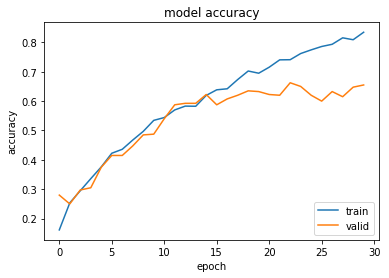

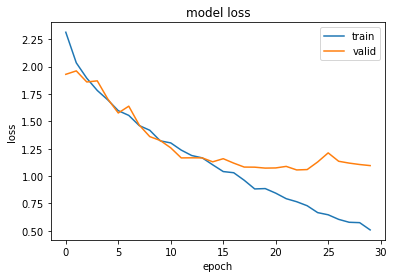

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [20]:
from keras.models import load_model
model = load_model("Checkpoints/8_faces/02_deeper/weights_epoch_030-1.10.hdf5")

In [21]:
preds = model.predict(X_valid)

In [22]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(np.argmax(Y_valid,axis=1),np.argmax(preds,axis=1)))
print("Acc = " ,np.sum(np.argmax(Y_valid,axis=1)==np.argmax(preds,axis=1))/len(preds))

[[38  1  3  0  1  1  3  3]
 [ 2 21  1 14  3  4  1  4]
 [ 2  2 29  3  0  2  2 10]
 [ 1  0  3 43  0  1  2  0]
 [ 0  3  0  1 41  0  0  5]
 [ 0  6  0  3  1 32  2  6]
 [ 4  4  4  2  4  4 25  3]
 [ 1  5  5  2  2  1  1 33]]
Acc =  0.655


# 03_deeperer

In [12]:
batch_size = 64
nb_classes = 8
nb_epoch = 50
img_rows, img_cols = 48, 48
input_shape = (img_rows, img_cols, 3)
kernel_size = (3, 3)
pool_size = (2, 2)
# 48*48 = 2'304

In [13]:
model = Sequential()
name = '03_deeperer'

# conv-layers

model.add(Convolution2D(32, kernel_size, padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(32, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))

model.add(Convolution2D(64, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(64,kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))

model.add(Convolution2D(128, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(128,kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))

model.add(Convolution2D(256, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(256,kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(256,kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))

model.add(Convolution2D(256, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(256,kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(256,kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))

# fc/softmax-part

model.add(Flatten())

model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
__________

In [15]:
model.evaluate(X_train,Y_train)

2000/2000 [==============================] - 18s 9ms/step


[2.0794617881774902, 0.108]

In [16]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir="tensorboard/8_faces/" + name + "/", 
        write_graph=True,
        histogram_freq=1)

In [17]:
os.makedirs("Checkpoints/8_faces/" + name + "/",exist_ok=True)       
checkpointer = keras.callbacks.ModelCheckpoint( 
        filepath =  "Checkpoints/8_faces/"+ name + "/"+"weights_epoch_{epoch:03d}-{val_loss:.2f}.hdf5",
        verbose = 1, 
        save_best_only = False,
        period = 10 )

In [18]:
history=model.fit(X_train, Y_train, 
                  batch_size=batch_size, 
                  epochs=nb_epoch,
                  verbose=2, 
                  validation_data=(X_valid, Y_valid),
                  callbacks=[tensorboard,checkpointer],)

Train on 2000 samples, validate on 400 samples
Epoch 1/50
 - 66s - loss: 2.3774 - acc: 0.1385 - val_loss: 10.3464 - val_acc: 0.1750
Epoch 2/50
 - 62s - loss: 2.1107 - acc: 0.1965 - val_loss: 9.6282 - val_acc: 0.1775
Epoch 3/50
 - 60s - loss: 2.0326 - acc: 0.1955 - val_loss: 2.1101 - val_acc: 0.2350
Epoch 4/50
 - 61s - loss: 2.0215 - acc: 0.1860 - val_loss: 1.9744 - val_acc: 0.2200
Epoch 5/50
 - 61s - loss: 1.9700 - acc: 0.2120 - val_loss: 2.4564 - val_acc: 0.1450
Epoch 6/50
 - 63s - loss: 1.9260 - acc: 0.2455 - val_loss: 2.5061 - val_acc: 0.1225
Epoch 7/50
 - 62s - loss: 1.8898 - acc: 0.2615 - val_loss: 2.3213 - val_acc: 0.1750
Epoch 8/50
 - 66s - loss: 1.8122 - acc: 0.2780 - val_loss: 2.1815 - val_acc: 0.1950
Epoch 9/50
 - 63s - loss: 1.7464 - acc: 0.3025 - val_loss: 2.4048 - val_acc: 0.2100
Epoch 10/50

Epoch 00010: saving model to Checkpoints/8_faces/03_deeperer/weights_epoch_010-2.24.hdf5
 - 64s - loss: 1.6671 - acc: 0.3600 - val_loss: 2.2384 - val_acc: 0.2525
Epoch 11/50
 - 62s - 

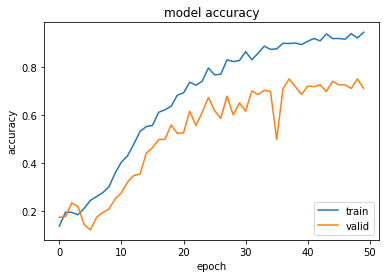

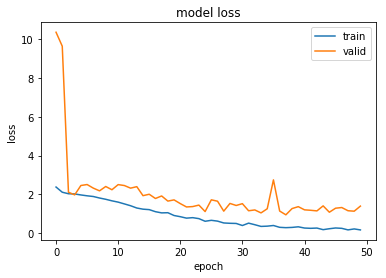

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [20]:
from keras.models import load_model
model = load_model("Checkpoints/8_faces/03_deeperer/weights_epoch_050-1.40.hdf5")

In [21]:
preds = model.predict(X_valid)

In [22]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(np.argmax(Y_valid,axis=1),np.argmax(preds,axis=1)))
print("Acc = " ,np.sum(np.argmax(Y_valid,axis=1)==np.argmax(preds,axis=1))/len(preds))

[[48  0  0  1  0  0  1  0]
 [ 8 16  0  1  6 12  5  2]
 [ 7  1 30  1  0  2  0  9]
 [ 3  1  0 39  2  2  3  0]
 [ 2  0  0  1 45  0  0  2]
 [ 4  3  0  0  1 38  4  0]
 [ 7  0  0  0  1  1 40  1]
 [ 9  2  1  0  1  5  3 29]]
Acc =  0.7125


In [ ]:
# bei mehr Paramtern wird langsamer gelernt, letzlich ist val_acc aber bessser, epochs muessen erhoeht werden
# erste convolution layers sollten nicht zu wenige sein
# fc layers sollten gleich gross sein bis verdichtung auf outputs
# kleine batchsize bringt etwas
# dropout bringt instabilitaet rein, zackige Kurven
# dropout vor oder nach relu?